In [1]:
import ee
import sys
from IPython.display import Image

In [2]:
try:
    ee.Initialize()
except:
    ee.Authenticate()

In [3]:
sys.path.append(r'C:\dem\anadem')
from source_code import *

In [4]:
# GET GEDI data

# gedi id example
gedi_id = 'LARSE/GEDI/GEDI02_A_002/GEDI02_A_2019114183224_O02064_04_T05177_02_003_01_V002'

geometry = ee.Geometry.Polygon([[[-54.22125770233209, -11.19073525160126],
          [-54.22125770233209, -13.109112122343381],
          [-52.096776501160214, -13.109112122343381],
          [-52.096776501160214, -11.19073525160126]]])

gedi_data = get_gedi_data(gedi_id,geometry)

gedi_data.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-52.32333255259082, -12.735705405262575]},
 'id': '00070000000000002d94',
 'properties': {'beam': 11,
  'degrade_flag': 0,
  'delta_time': 41370345.803371,
  'digital_elevation_model': 297.041504,
  'digital_elevation_model_srtm': 295.545105,
  'elev_highestreturn': 303.167908,
  'elev_lowestmode': 296.687195,
  'elevation_bias_flag': 0,
  'energy_total': 6315.20459,
  'landsat_treecover': 83,
  'landsat_water_persistence': 0,
  'lat_highestreturn': -12.735701560974121,
  'leaf_off_doy': 4,
  'leaf_off_flag': 0,
  'leaf_on_cycle': 0,
  'leaf_on_doy': 309,
  'local_beam_azimuth': -0.06648699939250946,
  'local_beam_elevation': 1.556615948677063,
  'lon_highestreturn': -52.323332,
  'minor_frame_number': 4,
  'modis_nonvegetated': 16,
  'modis_nonvegetated_sd': 13,
  'modis_treecover': 47,
  'modis_treecover_sd': 13,
  'num_detectedmodes': 1,
  'orbit_number': 2064,
  'pft_class': 2,
  'quality_flag': 1,
  'region_class

In [5]:
# get remote sensing data


start_date = '2020-01-01'
end_date = '2021-12-31'

rs_data = input_model(start_date,end_date,geometry).unmask(0)

rs_data.bandNames().getInfo()

['SR_B2',
 'SR_B3',
 'SR_B4',
 'SR_B5',
 'SR_B6',
 'SR_B7',
 'ST_B10',
 'EVI_L8',
 'NDVI_L8',
 'NDMI_L8',
 'NDWI_L8',
 'SAVI_L8',
 'MSAVI_L8',
 'SR_L8',
 'MSR_L8',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B11',
 'B12',
 'EVI_S2',
 'NDVI_S2',
 'NDMI_S2',
 'NDWI_S2',
 'SAVI_S2',
 'MSAVI_S2',
 'SR_S2',
 'MSR_S2',
 'copernicus',
 'slope',
 'water_mask']

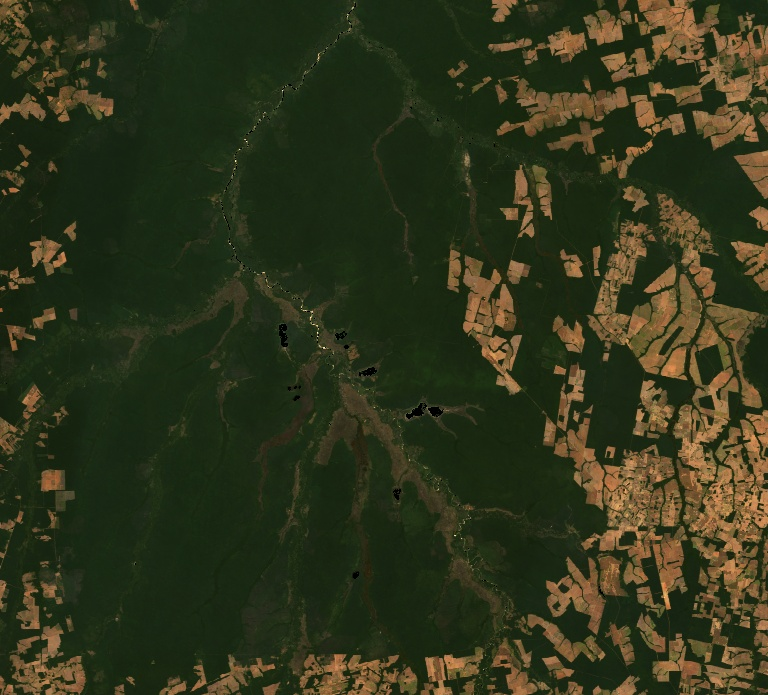

In [6]:
image_url = rs_data.select(['SR_B4', 'SR_B3', 'SR_B2'])\
    .getThumbURL({'min': 0.0, 'max': 0.23, 
                  'region': geometry, 'dimensions': 768})

Image(image_url, embed=True, format='png')

In [30]:
# Creating the table

def create_table(feat):
  
  red = rs_data.reduceRegion(
    reducer= ee.Reducer.first(),
    scale= 30,
    maxPixels= 10e12,
    geometry= feat.geometry(),
    )
  
  return ee.Feature(feat.geometry(),
      {
    'copernicus':red.getNumber('copernicus'),
    'NDMI_S2': red.getNumber('NDMI_S2'),
    'MSAVI_L8': red.getNumber('MSAVI_L8'),
    'water_mask':red.getNumber('water_mask'),
    'EVI_S2':red.getNumber('EVI_S2'),
    'MSAVI_S2':red.getNumber('MSAVI_S2'),
    'EVI_L8':red.getNumber('EVI_L8'),
    'slope':red.getNumber('slope'),
    'elev_highest_mode':feat.getNumber('elev_highestreturn'),
    'elev_lowest_mode':feat.getNumber('elev_lowestmode'),
    'rh20': feat.getNumber('rh20'),
    'rh25': feat.getNumber('rh25'),
    'rh40': feat.getNumber('rh40'),
    'rh50': feat.getNumber('rh50'),
    'rh60': feat.getNumber('rh60'),
    'rh70': feat.getNumber('rh70'),
    'rh80': feat.getNumber('rh80'),
    'rh85': feat.getNumber('rh85'),
    'rh90':  feat.getNumber('rh90'),
    'rh95': feat.getNumber('rh95'),
    'rh100': feat.getNumber('rh100'),
    'tandemx_dem': ee.Number(feat.getNumber('digital_elevation_model')),
  })
  


table = gedi_data.randomColumn().sort('random').limit(20000).map(create_table)



In [34]:
# Predict the vegetation bias

bands = ee.List(['copernicus','NDMI_S2','MSAVI_L8','water_mask','EVI_S2'])

# Parameters 
classifier_name = 'tree_boost'
numberoftrees = 200
max_samples = 20000
predictor = 'rh90'

# Machine learning predictor
vegetation_bias_0 = calc_forest_offset(rs_data, bands, classifier_name, numberoftrees, table, max_samples, predictor)

# Get fraction vegetation cover
fvc = fvc_func(start_date, end_date,geometry)

# Correct bias
vegetation_bias = ee.Image(vegetation_bias_0.get(0)).multiply(fvc)

In [18]:
# Export the image to Earth Engine Asset
task = ee.batch.Export.image.toAsset(**{
  'image': vegetation_bias,
  'description': 'vegetation_bias_example',
  'assetId': 'projects/et-brasil/assets/vegetation_bias_example',
  'scale': 30,
  'region': geometry
})

task.start()

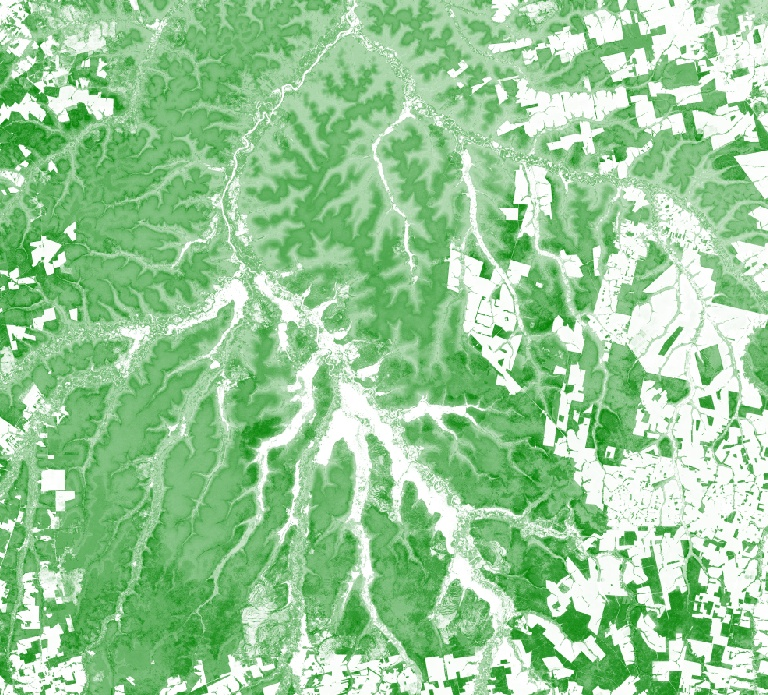

In [33]:
# Visualize

result = ee.Image('projects/et-brasil/assets/vegetation_bias_example')

image_url = result\
    .getThumbURL({'min': 0.0, 'max': 18, 'palette':['white','green'],
                  'region': geometry, 'dimensions': 768})

Image(image_url, embed=True, format='png')